In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

# Load the dataset
file_path = '../../Data/DOGE-USD.csv'  # Update this path to your actual file location
#file_path = 'DOGE-USD.csv'  # Update this path to your actual file location

eth_data = pd.read_csv(file_path)

# Convert 'Date' to datetime and sort by date
eth_data['Date'] = pd.to_datetime(eth_data['Date'])
eth_data = eth_data.sort_values('Date')

# Use only the 'Close' price for simplicity
eth_prices = eth_data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
eth_prices = scaler.fit_transform(eth_prices)

# Create patches
def create_patches(data, window_size, step_size):
    X, y = [], []
    for i in range(0, len(data) - window_size, step_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 30  # Number of days per patch
step_size = 1  # Step size between patches

X, y = create_patches(eth_prices, window_size, step_size)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Create DataLoader
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [2]:
class PatchTST(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, dropout=0.1):
        super(PatchTST, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.position_embedding = nn.Parameter(torch.zeros(1, window_size, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x) + self.position_embedding
        x = self.dropout(x)
        x = self.transformer(x)
        x = self.fc(x[:, -1, :])  # Use the output corresponding to the last patch
        return x

# Model parameters
input_dim = 1

In [3]:
import random

# Define the hyperparameter space
param_grid = {
    'embed_dim': [32, 64, 128],
    'num_heads': [2, 4, 8],
    'num_layers': [1, 2, 3],
    'dropout': [0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.0005, 0.0001]
}

# Function to sample hyperparameters
def sample_params(param_grid):
    params = {key: random.choice(values) for key, values in param_grid.items()}
    return params

def train_and_evaluate(params):
    embed_dim = params['embed_dim']
    num_heads = params['num_heads']
    num_layers = params['num_layers']
    dropout = params['dropout']
    learning_rate = params['learning_rate']
    
    model = PatchTST(input_dim, embed_dim, num_heads, num_layers, dropout)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # L2 regularization

    num_epochs = 50  # For quicker iteration during random search
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
    # Evaluate the model
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    
    avg_test_loss = test_loss / len(test_dataloader)
    return avg_test_loss

# Random search
num_iterations = 20  # Number of random samples
best_loss = float('inf')
best_params = None

for i in range(num_iterations):
    params = sample_params(param_grid)
    avg_test_loss = train_and_evaluate(params)
    
    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        best_params = params
    
    print(f"Iteration {i+1}/{num_iterations}, Loss: {avg_test_loss}, Params: {params}")

print(f"Best Loss: {best_loss}")
print(f"Best Params: {best_params}")

d:\Subject Material_8\Data analysis in business\Practices\Python\venv\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Iteration 1/20, Loss: 0.0003167032783884289, Params: {'embed_dim': 128, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.3, 'learning_rate': 0.0005}


d:\Subject Material_8\Data analysis in business\Practices\Python\venv\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Iteration 2/20, Loss: 0.0009944722488788621, Params: {'embed_dim': 128, 'num_heads': 8, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.0005}
Iteration 3/20, Loss: 0.00013523489701583458, Params: {'embed_dim': 64, 'num_heads': 4, 'num_layers': 1, 'dropout': 0.1, 'learning_rate': 0.0001}
Iteration 4/20, Loss: 0.0005638644257227757, Params: {'embed_dim': 64, 'num_heads': 2, 'num_layers': 1, 'dropout': 0.3, 'learning_rate': 0.0005}
Iteration 5/20, Loss: 0.0017879897911500717, Params: {'embed_dim': 32, 'num_heads': 2, 'num_layers': 1, 'dropout': 0.3, 'learning_rate': 0.0001}
Iteration 6/20, Loss: 0.0003510487315777157, Params: {'embed_dim': 32, 'num_heads': 8, 'num_layers': 1, 'dropout': 0.1, 'learning_rate': 0.0005}
Iteration 7/20, Loss: 0.0004111981813496511, Params: {'embed_dim': 64, 'num_heads': 2, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.0005}
Iteration 8/20, Loss: 0.00045843839013416855, Params: {'embed_dim': 32, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'learni

In [3]:
# Tham số
embed_dim = 64
num_heads = 4
num_layers = 1
dropout = 0.1
learning_rate = 0.0001

# Retrain the model with the best hyperparameters
# best_model = PatchTST(
#     input_dim,
#     best_params['embed_dim'],
#     best_params['num_heads'],
#     best_params['num_layers'],
#     best_params['dropout']
# )

best_model = PatchTST(
    input_dim,
    embed_dim,
    num_heads,
    num_layers,
    dropout
)

optimizer = optim.Adam(best_model.parameters(), lr=learning_rate, weight_decay=1e-5)  # L2 regularization
criterion = nn.MSELoss()

num_epochs = 100  # Final training with more epochs

for epoch in range(num_epochs):
    best_model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = best_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}')

# Evaluate the best model
best_model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_dataloader:
        outputs = best_model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

print(f'Final Test Loss: {test_loss/len(test_dataloader)}')

# Inverse transform the predicted values to original scale
inputs, targets = next(iter(test_dataloader))
predicted_prices = best_model(inputs).detach().numpy()
predicted_prices = scaler.inverse_transform(predicted_prices)

print(predicted_prices[:5])  # Print first 5 predicted prices

d:\Subject Material_8\Data analysis in business\Practices\Python\venv\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/100, Loss: 0.034255781987061105
Epoch 2/100, Loss: 0.008936712319458215
Epoch 3/100, Loss: 0.0054784001064642025
Epoch 4/100, Loss: 0.003937962625059299
Epoch 5/100, Loss: 0.002897206521690047
Epoch 6/100, Loss: 0.0029319346989116943
Epoch 7/100, Loss: 0.002744026824075263
Epoch 8/100, Loss: 0.0022065878365538083
Epoch 9/100, Loss: 0.0021419614907548143
Epoch 10/100, Loss: 0.0018845324023762562
Epoch 11/100, Loss: 0.001956581604948345
Epoch 12/100, Loss: 0.0017908823804949254
Epoch 13/100, Loss: 0.0017349944482702995
Epoch 14/100, Loss: 0.0019135186885250732
Epoch 15/100, Loss: 0.0018484122908072702
Epoch 16/100, Loss: 0.0016116054539452307
Epoch 17/100, Loss: 0.0013891317648813128
Epoch 18/100, Loss: 0.0016021954858539782
Epoch 19/100, Loss: 0.001582577425627581
Epoch 20/100, Loss: 0.001455153268276869
Epoch 21/100, Loss: 0.0015388455552359421
Epoch 22/100, Loss: 0.0015720897596717502
Epoch 23/100, Loss: 0.0015900177362103325
Epoch 24/100, Loss: 0.0013346190638306628
Epoch 25/

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_30444\637525108.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_test_prices = best_model(torch.tensor(X[test_indices], dtype=torch.float32)).detach().numpy()


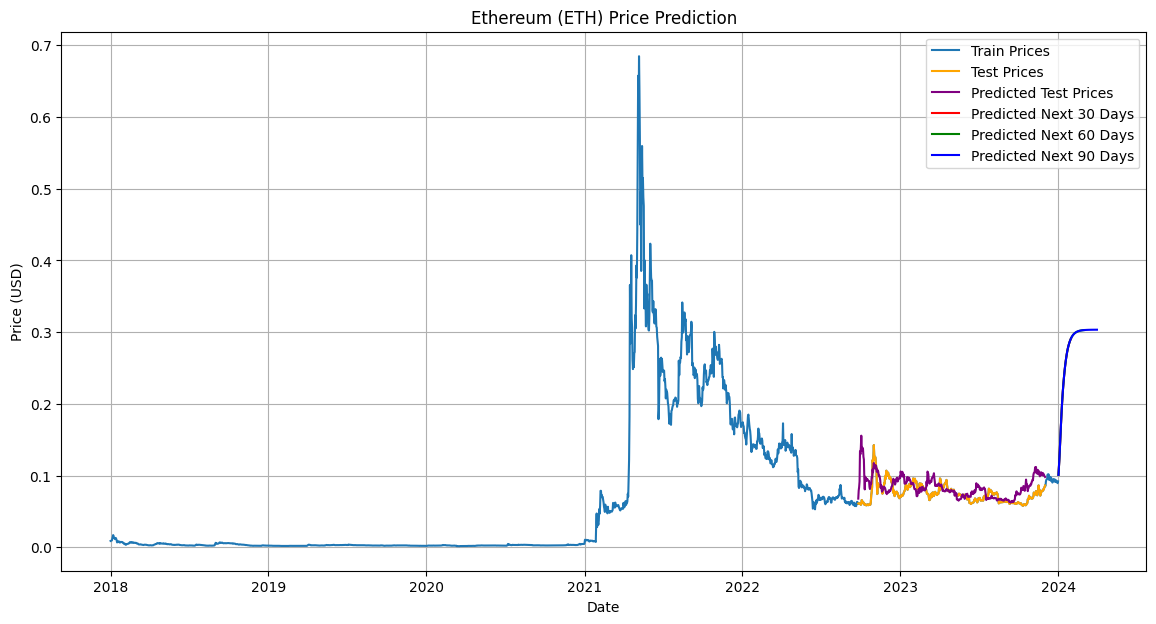

In [5]:
import matplotlib.pyplot as plt

# Function to predict the next n days
def predict_future(model, data, n_days, window_size):
    model.eval()
    predictions = []
    input_seq = data[-window_size:].reshape(1, window_size, 1)
    input_seq = torch.tensor(input_seq, dtype=torch.float32)

    with torch.no_grad():
        for _ in range(n_days):
            pred = model(input_seq)
            predictions.append(pred.item())
            input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)

    return np.array(predictions)

# Predict the next 30, 60, and 90 days
n_days_list = [30, 60, 90]
future_prices_list = [predict_future(best_model, eth_prices, n_days, window_size) for n_days in n_days_list]

# Inverse transform the predicted values to original scale
future_prices_list = [scaler.inverse_transform(future_prices.reshape(-1, 1)) for future_prices in future_prices_list]

# Prepare the data for plotting
dates = [pd.date_range(start=eth_data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_days) for n_days in n_days_list]
past_dates = eth_data['Date']
past_prices = scaler.inverse_transform(eth_prices)

# Extract test data for visualization
test_indices = list(range(train_size, len(dataset)))
test_dates = eth_data['Date'].iloc[test_indices]
test_prices = scaler.inverse_transform(eth_prices[test_indices])

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(past_dates, past_prices, label='Train Prices')
plt.plot(test_dates, test_prices, label='Test Prices', color='orange')
predicted_test_prices = best_model(torch.tensor(X[test_indices], dtype=torch.float32)).detach().numpy()
predicted_test_prices = scaler.inverse_transform(predicted_test_prices)
plt.plot(test_dates, predicted_test_prices, label='Predicted Test Prices', color='purple')
colors = ['red', 'green', 'blue']
labels = ['Predicted Next 30 Days', 'Predicted Next 60 Days', 'Predicted Next 90 Days']
for i in range(3):
    plt.plot(dates[i], future_prices_list[i], label=labels[i], color=colors[i])
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Ethereum (ETH) Price Prediction')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8424\637525108.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_test_prices = best_model(torch.tensor(X[test_indices], dtype=torch.float32)).detach().numpy()


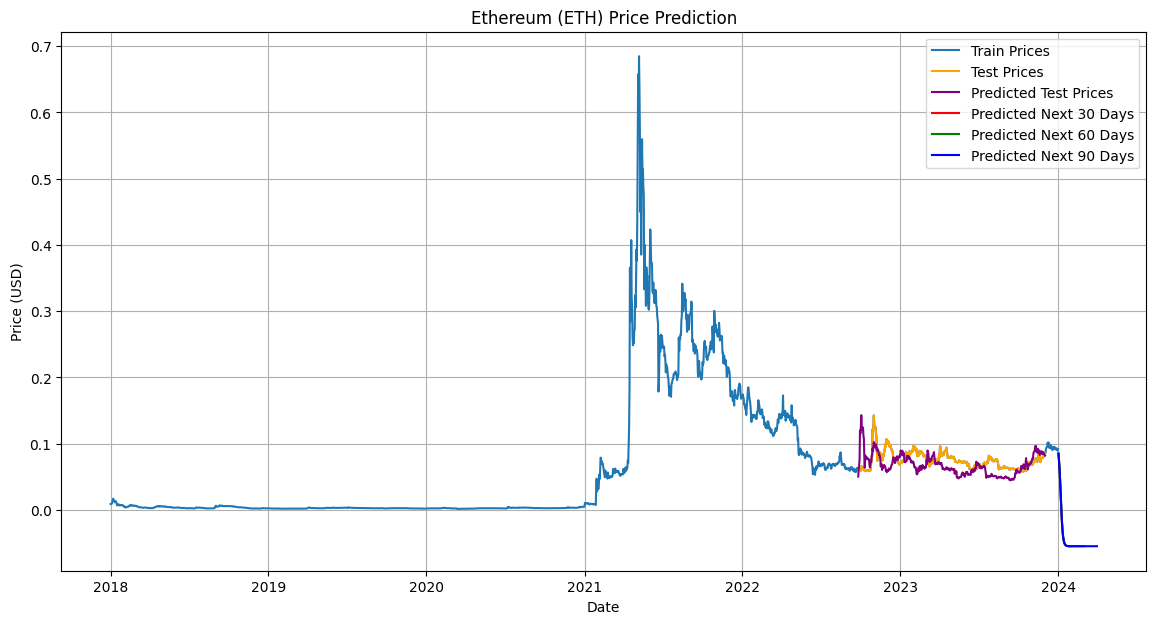

In [7]:
import matplotlib.pyplot as plt

# Function to predict the next n days
def predict_future(model, data, n_days, window_size):
    model.eval()
    predictions = []
    input_seq = data[-window_size:].reshape(1, window_size, 1)
    input_seq = torch.tensor(input_seq, dtype=torch.float32)

    with torch.no_grad():
        for _ in range(n_days):
            pred = model(input_seq)
            predictions.append(pred.item())
            input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)

    return np.array(predictions)

# Predict the next 30, 60, and 90 days
n_days_list = [30, 60, 90]
future_prices_list = [predict_future(best_model, eth_prices, n_days, window_size) for n_days in n_days_list]

# Inverse transform the predicted values to original scale
future_prices_list = [scaler.inverse_transform(future_prices.reshape(-1, 1)) for future_prices in future_prices_list]

# Prepare the data for plotting
dates = [pd.date_range(start=eth_data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_days) for n_days in n_days_list]
past_dates = eth_data['Date']
past_prices = scaler.inverse_transform(eth_prices)

# Extract test data for visualization
test_indices = list(range(train_size, len(dataset)))
test_dates = eth_data['Date'].iloc[test_indices]
test_prices = scaler.inverse_transform(eth_prices[test_indices])

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(past_dates, past_prices, label='Train Prices')
plt.plot(test_dates, test_prices, label='Test Prices', color='orange')
predicted_test_prices = best_model(torch.tensor(X[test_indices], dtype=torch.float32)).detach().numpy()
predicted_test_prices = scaler.inverse_transform(predicted_test_prices)
plt.plot(test_dates, predicted_test_prices, label='Predicted Test Prices', color='purple')
colors = ['red', 'green', 'blue']
labels = ['Predicted Next 30 Days', 'Predicted Next 60 Days', 'Predicted Next 90 Days']
for i in range(3):
    plt.plot(dates[i], future_prices_list[i], label=labels[i], color=colors[i])
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Ethereum (ETH) Price Prediction')
plt.legend()
plt.grid(True)
plt.show()

d:\Subject Material_8\Data analysis in business\Practices\Python\venv\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Metrics for split ratio 60.0% train and 40.0% test:
MSE: 12398.9567, MAE: 92.4243, RMSE: 111.3506, MAPE: 5.0594%



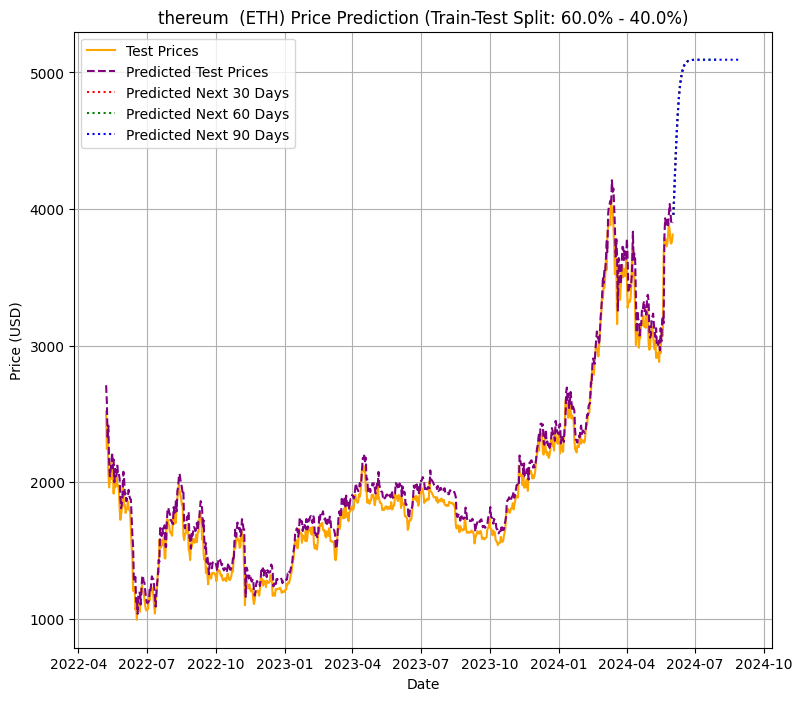

Metrics for split ratio 70.0% train and 30.0% test:
MSE: 9300.2871, MAE: 69.8477, RMSE: 96.4380, MAPE: 3.3373%



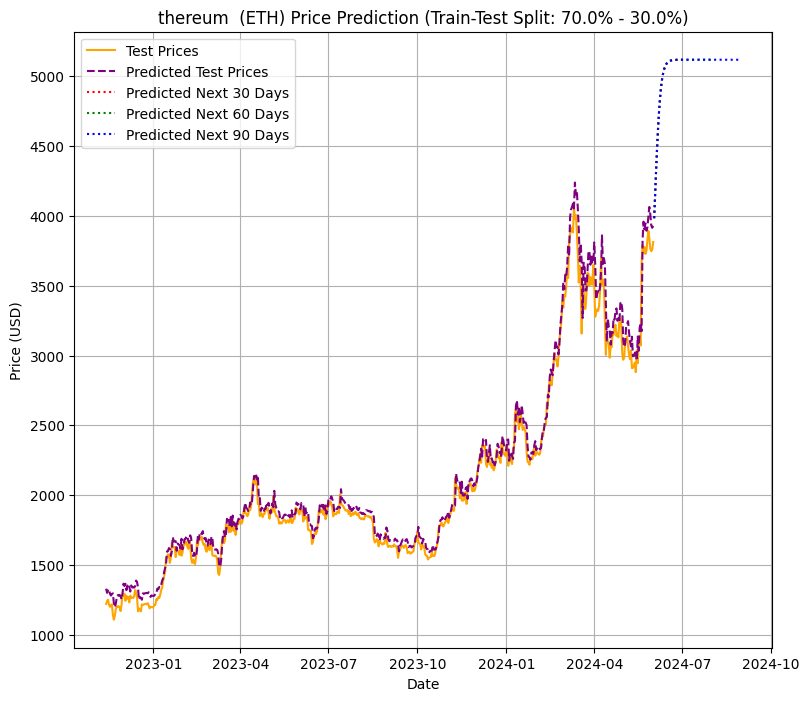

Metrics for split ratio 80.0% train and 20.0% test:
MSE: 13675.3765, MAE: 92.3825, RMSE: 116.9418, MAPE: 3.9066%



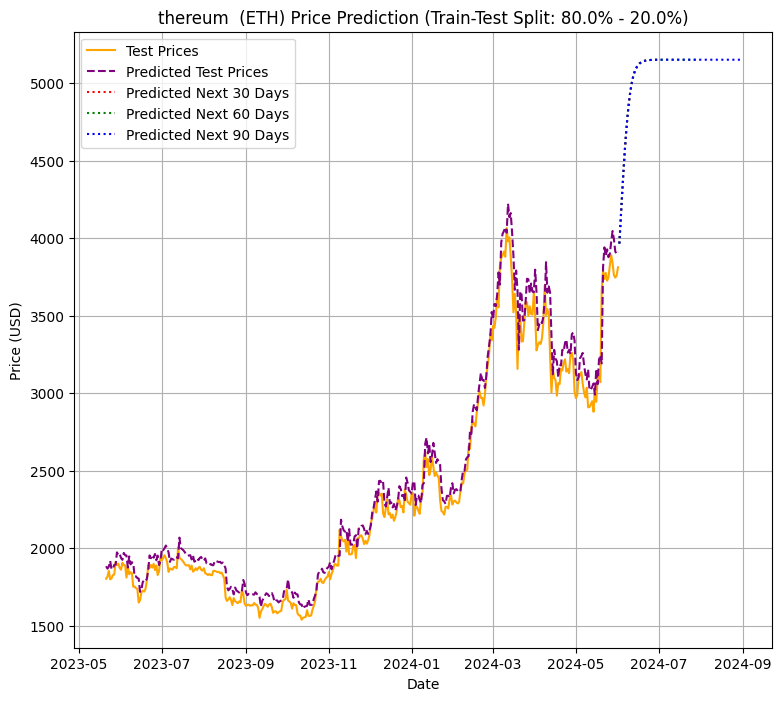

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Load the dataset
file_path = '../../Data/ETH-USD.csv'  # Update this path to your actual file location
eth_data = pd.read_csv(file_path)

# Convert 'Date' to datetime and sort by date
eth_data['Date'] = pd.to_datetime(eth_data['Date'])
eth_data = eth_data.sort_values('Date')

# Use only the 'Close' price for simplicity
eth_prices = eth_data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
eth_prices = scaler.fit_transform(eth_prices)

# Create patches
def create_patches(data, window_size, step_size):
    X, y = [], []
    for i in range(0, len(data) - window_size, step_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 30  # Number of days per patch
step_size = 1  # Step size between patches

X, y = create_patches(eth_prices, window_size, step_size)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Create DataLoader
dataset = TensorDataset(X, y)

# Define model
class PatchTST(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, dropout=0.1):
        super(PatchTST, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.position_embedding = nn.Parameter(torch.zeros(1, window_size, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x) + self.position_embedding
        x = self.dropout(x)
        x = self.transformer(x)
        x = self.fc(x[:, -1, :])  # Use the output corresponding to the last patch
        return x

# Model parameters
input_dim = 1
embed_dim = 64
num_heads = 4
num_layers = 1
dropout = 0.1
learning_rate = 0.0001

best_model = PatchTST(input_dim, embed_dim, num_heads, num_layers, dropout)
optimizer = optim.Adam(best_model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.MSELoss()

# Function to train and evaluate the model
def train_and_evaluate(model, train_dataloader, test_dataloader, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    
    avg_test_loss = test_loss / len(test_dataloader)
    return avg_test_loss

# Function to predict the next n days
def predict_future(model, data, n_days, window_size):
    model.eval()
    predictions = []
    input_seq = data[-window_size:].reshape(1, window_size, 1)
    input_seq = torch.tensor(input_seq, dtype=torch.float32)

    with torch.no_grad():
        for _ in range(n_days):
            pred = model(input_seq)
            predictions.append(pred.item())
            input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)

    return np.array(predictions)

from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, mae, rmse, mape


# Split ratios
split_ratios = [0.6, 0.7, 0.8]
n_days_list = [30, 60, 90]

# Placeholder for results
all_future_prices_list = []
all_predicted_test_prices = []
all_test_prices = []
all_test_dates = []

for split_ratio in split_ratios:
    train_size = int(len(dataset) * split_ratio)
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Train the model
    train_and_evaluate(best_model, train_dataloader, test_dataloader, num_epochs=100)

    # Predict future prices
    future_prices_list = [predict_future(best_model, eth_prices, n_days, window_size) for n_days in n_days_list]
    future_prices_list = [scaler.inverse_transform(future_prices.reshape(-1, 1)) for future_prices in future_prices_list]
    all_future_prices_list.append(future_prices_list)

    # Inverse transform past and test prices
    past_prices = scaler.inverse_transform(eth_prices)
    test_indices = list(range(len(eth_prices) - test_size, len(eth_prices)))
    test_dates = eth_data['Date'].iloc[test_indices]
    test_prices = scaler.inverse_transform(eth_prices[test_indices])

    # Predict test prices
    X_test = torch.tensor(eth_prices[test_indices[0] - window_size:test_indices[0]].reshape(1, window_size, 1), dtype=torch.float32)
    predicted_test_prices = []
    for idx in test_indices:
        pred = best_model(X_test).detach().numpy()
        predicted_test_prices.append(pred[0])
        next_input = eth_prices[idx].reshape(1, 1, 1)
        X_test = torch.cat((X_test[:, 1:, :], torch.tensor(next_input, dtype=torch.float32)), dim=1)
    predicted_test_prices = np.array(predicted_test_prices)
    predicted_test_prices = scaler.inverse_transform(predicted_test_prices.reshape(-1, 1))

    # Store results
    all_test_prices.append(test_prices)
    all_test_dates.append(test_dates)
    all_predicted_test_prices.append(predicted_test_prices)

    # Calculate and print metrics
    mse, mae, rmse, mape = calculate_metrics(test_prices, predicted_test_prices)
    print(f"Metrics for split ratio {split_ratio*100}% train and {100 - split_ratio*100}% test:")
    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}%\n")

    # Plotting the results
    plt.figure(figsize=(9, 8))

    # Plot past prices
    past_dates = eth_data['Date']
    # plt.plot(past_dates, past_prices, label='Train Prices')

    # Plot test and predicted prices for the current split
    plt.plot(test_dates, test_prices, label='Test Prices', color='orange')
    plt.plot(test_dates, predicted_test_prices, label='Predicted Test Prices', linestyle='dashed', color='purple')

    # Plot future predictions
    future_colors = ['red', 'green', 'blue']
    future_labels = ['Predicted Next 30 Days', 'Predicted Next 60 Days', 'Predicted Next 90 Days']

    for j in range(3):
        plt.plot(pd.date_range(start=past_dates.iloc[-1] + pd.Timedelta(days=1), periods=n_days_list[j]), 
                 future_prices_list[j], label=f'{future_labels[j]}', color=future_colors[j], linestyle='dotted')

    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.title(f'thereum  (ETH) Price Prediction (Train-Test Split: {split_ratio*100}% - {100 - split_ratio*100}%)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# Function to predict the next n days
def predict_future(model, data, n_days, window_size):
    model.eval()
    predictions = []
    input_seq = data[-window_size:].reshape(1, window_size, 1)
    input_seq = torch.tensor(input_seq, dtype=torch.float32)

    with torch.no_grad():
        for _ in range(n_days):
            pred = model(input_seq)
            predictions.append(pred.item())
            input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)

    return np.array(predictions)

# Split ratios
split_ratios = [0.6, 0.7, 0.8]
n_days_list = [30, 60, 90]

# Placeholder for results
all_future_prices_list = []
all_predicted_test_prices = []
all_test_prices = []
all_test_dates = []

for split_ratio in split_ratios:
    train_size = int(len(dataset) * split_ratio)
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Train the model
    train_and_evaluate(best_model, train_dataloader, test_dataloader, num_epochs=100)

    # Predict future prices
    future_prices_list = [predict_future(best_model, eth_prices, n_days, window_size) for n_days in n_days_list]
    future_prices_list = [scaler.inverse_transform(future_prices.reshape(-1, 1)) for future_prices in future_prices_list]
    all_future_prices_list.append(future_prices_list)

    # Inverse transform past and test prices
    past_prices = scaler.inverse_transform(eth_prices)
    test_indices = list(range(len(eth_prices) - test_size, len(eth_prices)))
    test_dates = eth_data['Date'].iloc[test_indices]
    test_prices = scaler.inverse_transform(eth_prices[test_indices])

    # Predict test prices
    X_test = torch.tensor(eth_prices[test_indices[0] - window_size:test_indices[0]].reshape(1, window_size, 1), dtype=torch.float32)
    predicted_test_prices = []
    for idx in test_indices:
        pred = best_model(X_test).detach().numpy()
        predicted_test_prices.append(pred[0])
        next_input = eth_prices[idx].reshape(1, 1, 1)
        X_test = torch.cat((X_test[:, 1:, :], torch.tensor(next_input, dtype=torch.float32)), dim=1)
    predicted_test_prices = np.array(predicted_test_prices)
    predicted_test_prices = scaler.inverse_transform(predicted_test_prices.reshape(-1, 1))

    # Store results
    all_test_prices.append(test_prices)
    all_test_dates.append(test_dates)
    all_predicted_test_prices.append(predicted_test_prices)

    # Plotting the results
    plt.figure(figsize=(14, 7))

    # Plot past prices
    past_dates = eth_data['Date']
    # plt.plot(past_dates, past_prices, label='Train Prices')

    # Plot test and predicted prices for the current split
    plt.plot(test_dates, test_prices, label='Test Prices', color='orange')
    plt.plot(test_dates, predicted_test_prices, label='Predicted Test Prices', linestyle='dashed', color='purple')

    # Plot future predictions
    future_colors = ['red', 'green', 'blue']
    future_labels = ['Predicted Next 30 Days', 'Predicted Next 60 Days', 'Predicted Next 90 Days']

    for j in range(3):
        plt.plot(pd.date_range(start=past_dates.iloc[-1] + pd.Timedelta(days=1), periods=n_days_list[j]), 
                 future_prices_list[j], label=f'{future_labels[j]}', color=future_colors[j], linestyle='dotted')

    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.title(f'Ethereum (ETH) Price Prediction (Train-Test Split: {split_ratio*100}% - {100 - split_ratio*100}%)')
    plt.legend()
    plt.grid(True)
    plt.show()

NameError: name 'train_and_evaluate' is not defined